# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [6]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, item in enumerate(train_loader):
        images, gt_labels = item
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        if use_cuda:
            images = images.cuda()
            labels = gt_labels.cuda()
        
        pred_labels = model(images)
        # TODO: compute negative log likelihood loss
        loss_fn =  nn.NLLLoss()
        loss = loss_fn(pred_labels, gt_labels)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print(f"Epoch: {epoch} [{i * len(images)}/{len(train_loader.dataset)}] \t Loss: {loss.item()}")

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [7]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [9]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.shape[0], -1)
        
        # TODO: run network layers
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        
        output = F.log_softmax(x, dim=1)
        
        return output

In [10]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        
        x = x.reshape(x.shape[0], -1)
        
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        
        output = F.log_softmax(x, dim=1)
        return output

In [25]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # Layer 1
        self.fc1 = nn.Linear(784,200)
        self.batchnorm1 = nn.BatchNorm1d(200)
        # Layer 2
        self.fc2 = nn.Linear(200,100)
        # Layer 3
        self.fc3 = nn.Linear(100,60)
        self.batchnorm3 = nn.BatchNorm1d(60)
        # Layer 4
        self.fc4 = nn.Linear(60,30)
        # Layer 5
        self.fc5 = nn.Linear(30,10)
        self.activation = nn.ReLU()

    def forward(self, x):
        
        x = x.reshape(x.shape[0], -1)
        
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        
        output = F.log_softmax(x, dim=1)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [ ]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        

    def forward(self, x):
        # TODO: run convolutional layers
        
        
        # TODO: reshape batch of images to batch of 1D vectors
        
        
        # TODO: run fully connected layers
       
        
        # TODO: compute log softmax over the output
        
        
        return output

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

    def forward(self, x):
        pass

In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

    def forward(self, x):
        pass

Epoch: 1 [0/60000] 	 Loss: 2.2892160415649414
Epoch: 1 [6400/60000] 	 Loss: 0.9487923383712769
Epoch: 1 [12800/60000] 	 Loss: 0.8016238212585449
Epoch: 1 [19200/60000] 	 Loss: 0.6923518180847168
Epoch: 1 [25600/60000] 	 Loss: 0.6853494048118591
Epoch: 1 [32000/60000] 	 Loss: 0.5587291121482849
Epoch: 1 [38400/60000] 	 Loss: 0.37960219383239746
Epoch: 1 [44800/60000] 	 Loss: 0.44616642594337463
Epoch: 1 [51200/60000] 	 Loss: 0.5056049227714539
Epoch: 1 [57600/60000] 	 Loss: 0.8049580454826355

Test set: Average loss: 0.5691, Accuracy: 7785/10000 (77.85%)



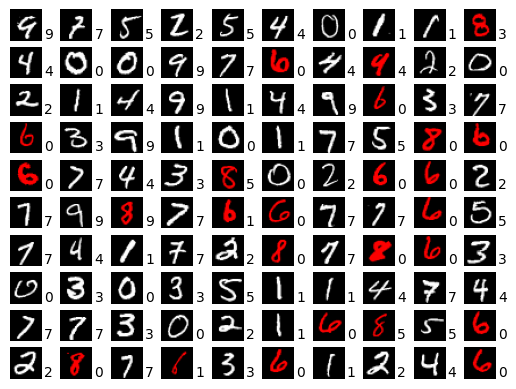

Epoch: 2 [0/60000] 	 Loss: 0.5545206069946289
Epoch: 2 [6400/60000] 	 Loss: 0.7509585618972778
Epoch: 2 [12800/60000] 	 Loss: 0.5493861436843872
Epoch: 2 [19200/60000] 	 Loss: 0.7874718904495239
Epoch: 2 [25600/60000] 	 Loss: 0.4438464939594269
Epoch: 2 [32000/60000] 	 Loss: 0.6687127947807312
Epoch: 2 [38400/60000] 	 Loss: 0.5664151906967163
Epoch: 2 [44800/60000] 	 Loss: 0.37046724557876587
Epoch: 2 [51200/60000] 	 Loss: 0.6742373704910278
Epoch: 2 [57600/60000] 	 Loss: 0.5559507012367249

Test set: Average loss: 0.5225, Accuracy: 7887/10000 (78.87%)



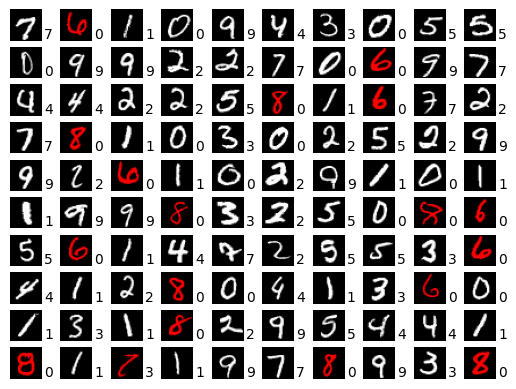

Epoch: 3 [0/60000] 	 Loss: 0.4777679443359375
Epoch: 3 [6400/60000] 	 Loss: 0.5290677547454834
Epoch: 3 [12800/60000] 	 Loss: 0.23485827445983887
Epoch: 3 [19200/60000] 	 Loss: 0.3296641409397125
Epoch: 3 [25600/60000] 	 Loss: 0.18141961097717285
Epoch: 3 [32000/60000] 	 Loss: 0.5517081618309021
Epoch: 3 [38400/60000] 	 Loss: 0.4876643717288971
Epoch: 3 [44800/60000] 	 Loss: 0.5299549102783203
Epoch: 3 [51200/60000] 	 Loss: 0.5099726915359497
Epoch: 3 [57600/60000] 	 Loss: 0.5630669593811035

Test set: Average loss: 0.5222, Accuracy: 7920/10000 (79.20%)



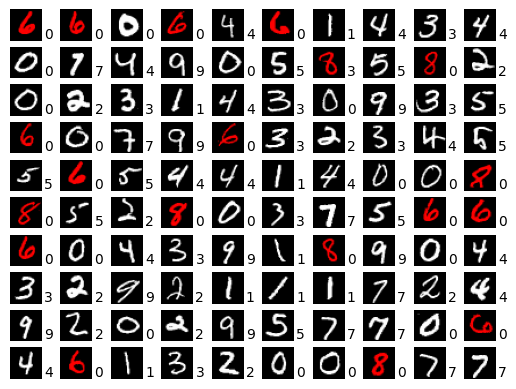

Epoch: 4 [0/60000] 	 Loss: 0.3521788418292999
Epoch: 4 [6400/60000] 	 Loss: 0.3684728443622589
Epoch: 4 [12800/60000] 	 Loss: 0.3265051245689392
Epoch: 4 [19200/60000] 	 Loss: 0.5790603160858154
Epoch: 4 [25600/60000] 	 Loss: 0.5843657851219177
Epoch: 4 [32000/60000] 	 Loss: 0.5428798198699951
Epoch: 4 [38400/60000] 	 Loss: 0.5910928249359131
Epoch: 4 [44800/60000] 	 Loss: 0.4701932370662689
Epoch: 4 [51200/60000] 	 Loss: 0.46910253167152405
Epoch: 4 [57600/60000] 	 Loss: 0.6052918434143066

Test set: Average loss: 0.5152, Accuracy: 7939/10000 (79.39%)



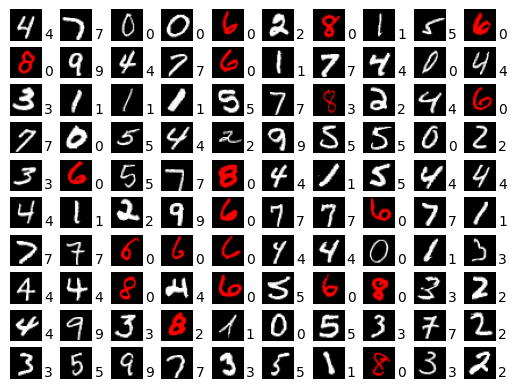

Epoch: 5 [0/60000] 	 Loss: 0.45433199405670166
Epoch: 5 [6400/60000] 	 Loss: 0.7869551181793213
Epoch: 5 [12800/60000] 	 Loss: 0.4095843434333801
Epoch: 5 [19200/60000] 	 Loss: 0.5722239017486572
Epoch: 5 [25600/60000] 	 Loss: 0.4045358896255493
Epoch: 5 [32000/60000] 	 Loss: 0.5580427646636963
Epoch: 5 [38400/60000] 	 Loss: 0.45174527168273926
Epoch: 5 [44800/60000] 	 Loss: 0.37657496333122253
Epoch: 5 [51200/60000] 	 Loss: 0.43197593092918396
Epoch: 5 [57600/60000] 	 Loss: 0.5066789388656616

Test set: Average loss: 0.5137, Accuracy: 7928/10000 (79.28%)



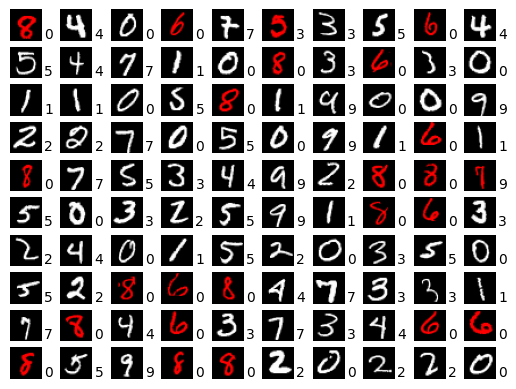

Epoch: 6 [0/60000] 	 Loss: 0.5412796139717102
Epoch: 6 [6400/60000] 	 Loss: 0.6506187915802002
Epoch: 6 [12800/60000] 	 Loss: 0.4318254590034485
Epoch: 6 [19200/60000] 	 Loss: 0.627895176410675
Epoch: 6 [25600/60000] 	 Loss: 0.44099634885787964
Epoch: 6 [32000/60000] 	 Loss: 0.5493114590644836
Epoch: 6 [38400/60000] 	 Loss: 0.5398637056350708
Epoch: 6 [44800/60000] 	 Loss: 0.5537979006767273
Epoch: 6 [51200/60000] 	 Loss: 0.612403929233551
Epoch: 6 [57600/60000] 	 Loss: 0.5793584585189819

Test set: Average loss: 0.5145, Accuracy: 7940/10000 (79.40%)



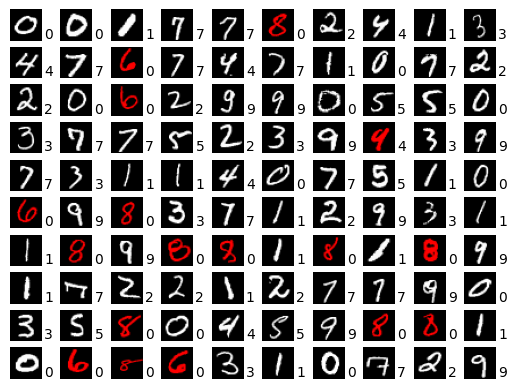

Epoch: 7 [0/60000] 	 Loss: 0.36002418398857117
Epoch: 7 [6400/60000] 	 Loss: 0.39644500613212585
Epoch: 7 [12800/60000] 	 Loss: 0.4700334668159485
Epoch: 7 [19200/60000] 	 Loss: 0.40717053413391113
Epoch: 7 [25600/60000] 	 Loss: 0.6193637251853943
Epoch: 7 [32000/60000] 	 Loss: 0.5415528416633606
Epoch: 7 [38400/60000] 	 Loss: 0.5396938323974609
Epoch: 7 [44800/60000] 	 Loss: 0.5986210107803345
Epoch: 7 [51200/60000] 	 Loss: 0.5044541954994202
Epoch: 7 [57600/60000] 	 Loss: 0.3969959318637848

Test set: Average loss: 0.5180, Accuracy: 7940/10000 (79.40%)



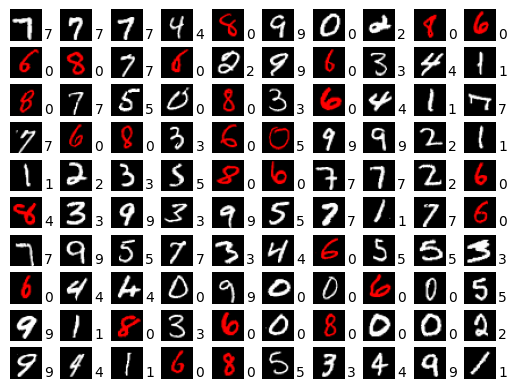

Epoch: 8 [0/60000] 	 Loss: 0.5879828929901123
Epoch: 8 [6400/60000] 	 Loss: 0.7222456336021423
Epoch: 8 [12800/60000] 	 Loss: 0.28809815645217896
Epoch: 8 [19200/60000] 	 Loss: 0.36115410923957825
Epoch: 8 [25600/60000] 	 Loss: 0.46776828169822693
Epoch: 8 [32000/60000] 	 Loss: 0.6125330328941345
Epoch: 8 [38400/60000] 	 Loss: 0.3470638394355774
Epoch: 8 [44800/60000] 	 Loss: 0.4319809079170227
Epoch: 8 [51200/60000] 	 Loss: 0.4724805951118469
Epoch: 8 [57600/60000] 	 Loss: 0.38729438185691833

Test set: Average loss: 0.5191, Accuracy: 7946/10000 (79.46%)



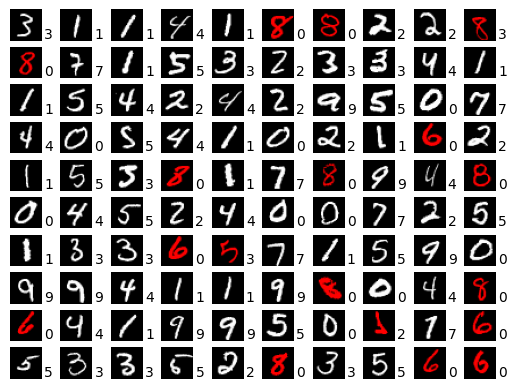

Epoch: 9 [0/60000] 	 Loss: 0.3602709174156189
Epoch: 9 [6400/60000] 	 Loss: 0.43380528688430786
Epoch: 9 [12800/60000] 	 Loss: 0.287876695394516
Epoch: 9 [19200/60000] 	 Loss: 0.5401283502578735
Epoch: 9 [25600/60000] 	 Loss: 0.6836645603179932
Epoch: 9 [32000/60000] 	 Loss: 0.5397895574569702
Epoch: 9 [38400/60000] 	 Loss: 0.29038068652153015
Epoch: 9 [44800/60000] 	 Loss: 0.46792924404144287
Epoch: 9 [51200/60000] 	 Loss: 0.6838806867599487
Epoch: 9 [57600/60000] 	 Loss: 0.3242471516132355

Test set: Average loss: 0.5228, Accuracy: 7947/10000 (79.47%)



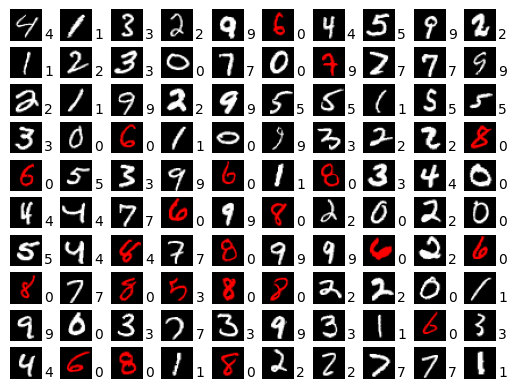

Epoch: 10 [0/60000] 	 Loss: 0.2168613225221634
Epoch: 10 [6400/60000] 	 Loss: 0.4053652882575989
Epoch: 10 [12800/60000] 	 Loss: 0.5037966966629028
Epoch: 10 [19200/60000] 	 Loss: 0.4677543640136719
Epoch: 10 [25600/60000] 	 Loss: 0.4682174324989319
Epoch: 10 [32000/60000] 	 Loss: 0.4334239065647125
Epoch: 10 [38400/60000] 	 Loss: 0.3972627520561218
Epoch: 10 [44800/60000] 	 Loss: 0.4678405523300171
Epoch: 10 [51200/60000] 	 Loss: 0.3336101770401001
Epoch: 10 [57600/60000] 	 Loss: 0.39607685804367065

Test set: Average loss: 0.5232, Accuracy: 7944/10000 (79.44%)



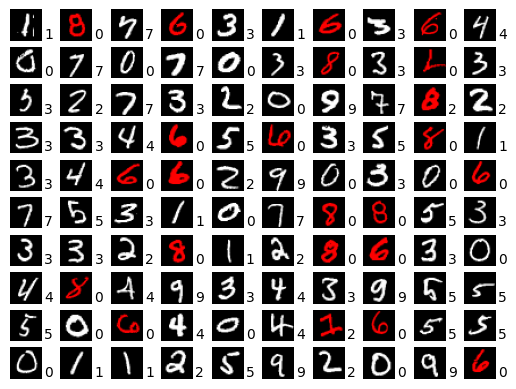

In [26]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")